In [45]:
import cv2

from PIL import Image
import numpy as np
import sys
import os
import csv
import dlib
import scipy
from scipy import ndimage
from skimage import measure, io, img_as_ubyte
import matplotlib.pyplot as plt
from skimage.color import label2rgb, rgb2gray
import numpy as np
import glob
import pandas as pd
from sklearn.cluster import KMeans #for clusterin
from os import listdir
from os.path import isfile, join
from imblearn.over_sampling import SMOTE

In [46]:
import numpy as np  
import cv2  
import dlib  
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import os
import imutils
import math

def get_norm(image,x1,y1,x2,y2):
    x = (int(image[x1][y1][0])-int(image[x2][y2][0]))**2
    y = (int(image[x1][y1][1])-int(image[x2][y2][1]))**2
    z = (int(image[x1][y1][2])-int(image[x2][y2][2]))**2
    norm = x + y + z
    return norm

def get_min(image,x1,y1):
    x = int(image[x1][y1][0])
    y = int(image[x1][y1][1])
    z = int(image[x1][y1][2])
    return np.min([x,y,z])

def get_color(image,x,y,gray):
    if gray == 1: image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.min(image[y,x])
    
def get_lum(image,x,y,w,h,k,gray):
    if gray == 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    i1 = range(int(-w/2),int(w/2))
    j1 = range(0,h)
    lumar = np.zeros((len(i1),len(j1)))
    for i in i1:
        for j in j1:
            lum = np.min(image[y+k*h,x+i])
            lumar[i][j] = lum
    
    return np.min(lumar)

def get_ave_down(image,x,y,h,w):
    ave = np.min(image[x-w:x+w,y-h:y])
    return int(ave)
def get_ave_up(image,x,y,h,w):
    ave = np.max(image[x-w:x+w,y:y+h])
    return int(ave)

def d(landmarks,index1,index2):
#get distance between i1 and i2
    x1 = landmarks[int(index1)][0]
    y1 = landmarks[int(index1)][1]
    x2 = landmarks[int(index2)][0]
    y2 = landmarks[int(index2)][1]
    x_diff = (x1 - x2)**2
    y_diff = (y1 - y2)**2
    dist = math.sqrt(x_diff + y_diff)
    return dist

def q(landmarks,index1,index2):
#get angle between a i1 and i2
    x1 = landmarks[int(index1)][0]
    y1 = landmarks[int(index1)][1]
    x2 = landmarks[int(index2)][0]
    y2 = landmarks[int(index2)][1]
    
    x_diff = float(x1 - x2)
    if (y1 == y2): y_diff = 0.1
    if (y1 < y2): y_diff = float(np.absolute(y1 - y2))
    if (y1 > y2):
        y_diff = 0.1
    
        print("Error: Facial feature located below chin.")
    
    return np.absolute(math.atan(x_diff/y_diff))

In [47]:
b=[]
def features(image, faceCascade):
    global data    
    faces = faceCascade.detectMultiScale(image, 
                                         scaleFactor = 1.1, #1.1 
                                         minNeighbors = 9, 
                                         minSize = (30, 30), 
                                         flags = cv2.CASCADE_SCALE_IMAGE  ) 
    for (x, y, w, h) in faces:
        y=int(0.95*y)
        h=int(1.05*h)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), 2)
        dlib_rect = dlib.rectangle(int(x), int(0.95*y), int(x + w), int(y + 1.05*h))
        detected_landmarks = predictor(image, dlib_rect).parts()
        landmarks = np.matrix([[p.x, p.y] for p in detected_landmarks]) 
        image_copy = image.copy() 
        for idx, point in enumerate(landmarks): 
            pos = (point[0, 0], point[0, 1])
            cv2.circle(image_copy, pos, 3, color=(255, 153, 0))
            p27 = (landmarks[27][0,0],landmarks[27][0,1])
            x = p27[0]
            y1 = p27[1]
            gray = 0
            diff = get_lum(image,x,y1,8,1,-1,gray)
                #print(diff)
            limit = diff-5
                
            while (diff > limit):
                    y1 = int(y1 - 1)
                    diff = get_lum(image,x,y1,6,1,-1,gray)
            cv2.circle(image_copy, (x,y1), 3, color=(255, 153, 0))
            plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
            cv2.imwrite("agreene.jpg", image_copy)
                #plt.show()
            cv2.waitKey(0)
            lmark = landmarks.tolist()
            p68 = ((x,y1))
            lmark.append(p68)
            g=[]
            h=[]
                
            fwidth = d(lmark,0,16)
            fheight = d(lmark,8,68)
            c=(fheight/fwidth)
            jwidth = d(lmark,4,12)
            j=(jwidth/fwidth)
               
            hchinmouth = d(lmark,57,8)
            e=(hchinmouth/fwidth)
            ref = q(lmark,27,8)
            f=ref
            for k in range(0,17):
              if k != 8:
               theta = q(lmark,k,8)
               g.append(theta)
            x=np.array(g)
            for k in range(1,8):
              dist = d(lmark,k,16-k)
              h.append(dist/fwidth)
            y=np.array(h)
            z=np.concatenate([x,y])
            #k=[label_2,c,j,e,f]
            
            #feature=np.concatenate([k,z])
        
                
        feature=[diff,fwidth, fheight,c,jwidth,j,hchinmouth,e,ref]   # dfmaster = pd.concat( df_t,   data)
        data_1=np.concatenate([feature,z])
        data=data_1.tolist()
        #print(data)
    return data


In [201]:

train_data ='E:/projects/Face shape classification/spyder/data/crop img/*'
faceCascade =  cv2.CascadeClassifier('C:/Users/2109902/My program/face_feature_Randomforest/haarcascade_frontalface_default.xml')
predictor_path= 'C:/Users/2109902/My program/face_feature_Randomforest/shape_predictor_68_face_landmarks.dat'
  
predictor = dlib.shape_predictor(predictor_path) 

so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
so_Eum
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located below chin.
Error: Facial feature located belo

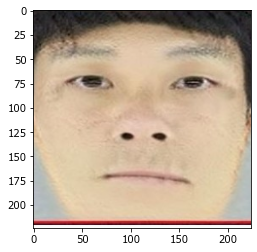

In [202]:
SIZE=224

train_images=[]
train_labels=[]
feature_train1=[]
for directory_path in glob.glob(train_data):
    label_1=directory_path.split("\\")[-1]
    print(label_1)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        
     
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        plt.imshow(img)
        features_1 = features(img ,faceCascade)
        print(label_1)
        face= faceCascade.detectMultiScale(img, 1.01, 9,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
      
        for (x,y,w,h) in face:
          y=int(0.95*y)
          h=int(1.05*h)
        images=img[x:x+w, y:y+h]
        images = cv2.resize(images, (SIZE, SIZE))
        train_images.append(images)
        feature_train1.append(features_1)       #Train _Image _features
        train_labels.append( label_1) 
        # Train labels
        #images_1=images_1.tolist()
             # Train Images


train_label=np.array(train_labels)
train_images_1=np.array(train_images) 
feature_train1=np.array(feature_train1)


In [257]:
train_images=np.array(train_images_1)
train_labels=np.array(train_labels)

feature_train1=np.array(feature_train1)
print(train_images.shape)

print(train_labels.shape)
feature_train1.shape
#np.save("E:/projects/Face shape classification/spyder/results/extracted_feature_crop_image.npy",feature_train1)


(585, 224, 224, 3)
(585,)


In [260]:
#np.load('E:/projects/Face shape classification/spyder/results/extracted_feature_crop_image.npy')

In [204]:
y_train=pd.DataFrame(train_labels)
label1= y_train.value_counts()
train_labels

array(['so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum',
       'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_Eum', 'so_E

In [205]:
label=train_labels
label.shape

(585,)

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import cv2
import tensorflow
from tensorflow.keras import backend
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from tensorflow.keras.layers.normalization import BatchNormalization
import os
#import seaborn as sns
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models, losses
#from tensorflow.python import _pywrap_bfloat16

In [208]:
# #VGG19

train_images=train_images/255
model=tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [209]:
# Inception v3

# import tensorflow as tf
# train_images=train_images/255
# model=tf.keras.applications.InceptionV3(
#     include_top=True,
#     weights="imagenet",                       ##  58%
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

In [210]:
feature_extractor_train=model.predict(train_images)
#feature_extractor_test=VGG_model.predict(x_test)


In [213]:
print(feature_extractor_train.shape)
train_labels.shape

(585, 1000)


(585,)

In [214]:
feature_train2 = feature_extractor_train.reshape(feature_extractor_train.shape[0],-1)
train_label1=train_labels

In [215]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(feature_train2)
feature_train2 = imputer.transform(feature_train2)


In [216]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(feature_train1)
feature_train1 = imputer.transform(feature_train1)

In [217]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
model =RandomForestClassifier(max_depth=1) #For Boruta
from boruta import BorutaPy
feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=101)
feat_selector.fit(feature_train2,train_label1)
print(feat_selector.support_)  #Should we accept the featur
print(feat_selector.ranking_) #Rank 1 is the best
X_filtered1 = feat_selector.transform(feature_train2)  #Apply feature selection and return transformed data



Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [218]:
print(feature_train1.shape)
print(X_filtered1.shape)

(585, 32)
(585, 128)


In [219]:

feature_train=np.concatenate([X_filtered1,feature_train1],axis=1)
print(feature_train.shape)
final_label=train_label1
print(final_label.shape)

(585, 160)
(585,)


In [220]:
from sklearn.preprocessing import MinMaxScaler

#Final_selected =  (Final_selected - Final_selected.mean()) / Final_selected.std()
scaler = MinMaxScaler(feature_range=(0, 1))
feature_train= scaler.fit_transform(feature_train)

train_labels.shape

(585,)

In [221]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_label1, test_labels = train_test_split(feature_train, train_labels, test_size = 0.20, random_state =9, stratify=train_labels)

In [222]:
print("Shape of Train Features",train_features.shape)
print("Shape of Train Labels",train_label1.shape)

print("Shape of Test Features",test_features.shape)
print("Shape of Test Labels",test_labels.shape)

Shape of Train Features (468, 160)
Shape of Train Labels (468,)
Shape of Test Features (117, 160)
Shape of Test Labels (117,)


In [223]:
X_train=train_features
y_train=train_label1
X_test=test_features
y_test=test_labels

In [265]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=101)
RF.fit(X_train, y_train)
prediction =RF.predict(X_test)

In [266]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(classification_report(y_test, prediction))
print(accuracy_score(y_test, prediction))
print(confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

      Ta_Eum       0.80      0.53      0.64        15
     Ta_Yang       1.00      0.68      0.81        22
      so_Eum       0.89      0.85      0.87        40
     so_Yang       0.67      0.90      0.77        40

    accuracy                           0.79       117
   macro avg       0.84      0.74      0.77       117
weighted avg       0.82      0.79      0.79       117

0.7948717948717948
[[ 8  0  0  7]
 [ 0 15  1  6]
 [ 1  0 34  5]
 [ 1  0  3 36]]


In [269]:
###Save model
import pickle
filename='E:/projects/Face shape classification/spyder/results/model_crop_image'
pickle.dump(RF,open(filename, 'wb'))



In [268]:
##Load model
loaded_model=pickel.load(open(filename,'rb'))
loaded_model.predict(X_test)

NameError: name 'pickel' is not defined

In [226]:
from sklearn.ensemble import GradientBoostingClassifier
model_1= GradientBoostingClassifier(learning_rate=0.001, n_estimators=2500,max_depth=16, min_samples_split=12, min_samples_leaf=20, subsample=1,max_features='sqrt', random_state=101)
# GBM = GradientBoostingClassifier(random_state=101)
model_1.fit(X_train, y_train)
prediction = model_1.predict(X_test)

In [227]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(classification_report(y_test, prediction))
print(accuracy_score(y_test, prediction))
cm=confusion_matrix(y_test, prediction)

              precision    recall  f1-score   support

      Ta_Eum       0.80      0.53      0.64        15
     Ta_Yang       1.00      0.68      0.81        22
      so_Eum       0.87      0.82      0.85        40
     so_Yang       0.65      0.88      0.74        40

    accuracy                           0.78       117
   macro avg       0.83      0.73      0.76       117
weighted avg       0.81      0.78      0.78       117

0.7777777777777778


In [270]:
##Save model
import pickle
filename='E:/projects/Face shape classification/spyder/results/model_crop_image_GBM'
pickle.dump(model_1,open(filename, 'wb'))

In [261]:
from xgboost import XGBClassifier
XGB = XGBClassifier(random_state=101,silent=False, 
                      scale_pos_weight=4,
                      learning_rate=0.0001,  
                      colsample_bytree = 0.4,
                      subsample = 0.99,
                      objective='binary:logistic', 
                      n_estimators=2300, 
                      reg_alpha = 0.099,
                      max_depth=7, 
                      gamma=5)
XGB.fit(X_train, y_train)
prediction = XGB.predict(X_test)
print(prediction)

[10:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:32:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
['Ta_Yang' 'so_Eum' 'so_Yang' 'so_Eum' 'Ta_Yang' 'so_Yang' 'so_Yang'
 'so_Yang' 'so_Eum' 'so_Eum' 'so_Eum' 'so_Yang' 'so_Yang' 'so_Yang'
 'so_Yang' 'so_Yang' 'so_Eum' 'Ta_Yang' 'so_Eum' 'so_Yang' 'so_Eum'
 'so_Eum' 'so_Yang' 'so_Yang' 'so_Yang' 'so_Eum' 

In [262]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(classification_report(y_test, prediction))
print(accuracy_score(y_test, prediction))
cm=confusion_matrix(y_test, prediction)

              precision    recall  f1-score   support

      Ta_Eum       0.78      0.47      0.58        15
     Ta_Yang       1.00      0.68      0.81        22
      so_Eum       0.89      0.85      0.87        40
     so_Yang       0.67      0.93      0.78        40

    accuracy                           0.79       117
   macro avg       0.84      0.73      0.76       117
weighted avg       0.82      0.79      0.79       117

0.7948717948717948


In [271]:
##Save model
import pickle
filename='E:/projects/Face shape classification/spyder/results/model_crop_image_XGB'
pickle.dump(XGB,open(filename, 'wb'))

In [241]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(max_iter=3000,activation='relu', learning_rate_init=0.0001,shuffle=True,
                    learning_rate='constant', beta_1=0.9988, beta_2=0.999 , momentum=0.999,
                    power_t=0.9888, solver='lbfgs', alpha=1e-9, random_state=101)
MLP.fit(X_train, y_train)
prediction = MLP .predict(X_test)

In [238]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(classification_report(y_test, prediction))
print(accuracy_score(y_test, prediction))
print(confusion_matrix(y_test, prediction))
cm=confusion_matrix(y_test, prediction)

              precision    recall  f1-score   support

      Ta_Eum       0.53      0.60      0.56        15
     Ta_Yang       0.90      0.82      0.86        22
      so_Eum       0.85      0.88      0.86        40
     so_Yang       0.74      0.72      0.73        40

    accuracy                           0.78       117
   macro avg       0.76      0.75      0.75       117
weighted avg       0.78      0.78      0.78       117

0.7777777777777778
[[ 9  1  1  4]
 [ 1 18  1  2]
 [ 1  0 35  4]
 [ 6  1  4 29]]
